Utilizes the ResNet50 model for transfer learning, exploring:
- Fine-tuning the model to improve classification accuracy.
- Prediction accuracy and complexity metrics as a function of model pruning.

In [0]:
# "standard"
import numpy as np
import pandas as pd

# machine learning and statistics
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import EarlyStopping
from keras import applications, models, layers, optimizers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras.utils import to_categorical

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# misc
from IPython.display import clear_output

# src
import sys
sys.path.append('/Workspace/Users/bjedelma@gmail.com/Alzheimers-MRI-Classification/src')
from visualize import visualize_training
from custom_pruning import global_prune_model
from data_io import save_model_s3, load_model_s3, save_pickle_s3, load_pickle_s3

clear_output(wait=False)

Mount AWS S3 bucket containing processed data

In [0]:
ACCESS_KEY = dbutils.secrets.get(scope="brad-aws", key="access_key")
SECRET_KEY= dbutils.secrets.get(scope="brad-aws", key="secret_key")

# specify bucket and mount point
AWS_S3_BUCKET = "databricks-workspace-stack-brad-personal-bucket/AD_MRI_classification/raw/"
MOUNT_NAME = f"/mnt/{AWS_S3_BUCKET.split('/')[-2]}"
SOURCE_URL = f"s3a://{AWS_S3_BUCKET}"
EXTRA_CONFIGS = { "fs.s3a.access.key": ACCESS_KEY, "fs.s3a.secret.key": SECRET_KEY}

# mount bucket
if any(mount.mountPoint == MOUNT_NAME for mount in dbutils.fs.mounts()):
    print(f"{MOUNT_NAME} is already mounted.")
else:
    dbutils.fs.mount(SOURCE_URL, MOUNT_NAME, extra_configs = EXTRA_CONFIGS)
    print(f"{MOUNT_NAME} is now mounted.")

/mnt/raw is already mounted.


In [0]:
# Load data file and unpack contents
bucket_name="databricks-workspace-stack-brad-personal-bucket"
s3_file_name='AD_MRI_classification/preprocessed/data_preprocessed.pkl'
data=load_pickle_s3(bucket_name, s3_file_name, dbutils)

train_data=data['train_data']
train_lab=data['train_labels']
test_data=data['test_data']
test_lab=data['test_labels']
    
# Convert labels to categorical
train_lab_cat = to_categorical(train_lab.astype('int8'), num_classes=4)
test_lab_cat = to_categorical(test_lab.astype('int8'), num_classes=4)

Load and adapt ResNet50

In [0]:
# load ResNet50
res_model = applications.ResNet50(
    include_top=False,
    weights=None,
    input_shape=(train_data.shape[1], train_data.shape[2], 3)
)
clear_output(wait=False)

# Freeze all layers except the last block
for layer in res_model.layers[:-10]:
    layer.trainable = False

# Print layers to verify
for i, layer in enumerate(res_model.layers[140:], start=140):
    print(f"Layer {i}: {layer.name}, Trainable: {layer.trainable}")

# Add a Conv2D layer to convert grayscale images to 3 channels
input_layer = layers.Input(shape=(128, 128, 1))
x = layers.Conv2D(3, (3, 3), padding='same')(input_layer)
x = res_model(x)
x = layers.Flatten()(x)
x = layers.Dense(len(np.unique(train_lab)), activation='softmax')(x)  # Add Dense layer with number of unique classes

Layer 140: conv4_block6_3_bn, Trainable: False
Layer 141: conv4_block6_add, Trainable: False
Layer 142: conv4_block6_out, Trainable: False
Layer 143: conv5_block1_1_conv, Trainable: False
Layer 144: conv5_block1_1_bn, Trainable: False
Layer 145: conv5_block1_1_relu, Trainable: False
Layer 146: conv5_block1_2_conv, Trainable: False
Layer 147: conv5_block1_2_bn, Trainable: False
Layer 148: conv5_block1_2_relu, Trainable: False
Layer 149: conv5_block1_0_conv, Trainable: False
Layer 150: conv5_block1_3_conv, Trainable: False
Layer 151: conv5_block1_0_bn, Trainable: False
Layer 152: conv5_block1_3_bn, Trainable: False
Layer 153: conv5_block1_add, Trainable: False
Layer 154: conv5_block1_out, Trainable: False
Layer 155: conv5_block2_1_conv, Trainable: False
Layer 156: conv5_block2_1_bn, Trainable: False
Layer 157: conv5_block2_1_relu, Trainable: False
Layer 158: conv5_block2_2_conv, Trainable: False
Layer 159: conv5_block2_2_bn, Trainable: False
Layer 160: conv5_block2_2_relu, Trainable: Fal

In [0]:
# Combine new input layer to ResNet50
model = models.Model(inputs=input_layer, outputs=x)
std_learning_rate = 1e-4
model.compile(optimizer = keras.optimizers.Adam(learning_rate = std_learning_rate),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy']
)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 3)    │            30 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 4, 4, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │       131,076 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,718,818 (90.48 MB)

 Trainable params: 4,596,770 (17.54 MB)

 Non-trainable params: 19,122,048 (72.94 MB)

In [0]:
# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_data,
    train_lab_cat,
    epochs=20, 
    validation_data=(test_data, test_lab_cat),
    callbacks=[early_stopping]
)

clear_output(wait=False)

In [0]:
# Save model and history files
bucket_name="databricks-workspace-stack-brad-personal-bucket"
s3_file_path='AD_MRI_classification/results/model_resnet50.h5'
save_model_s3(model, bucket_name, s3_file_path, dbutils)

bucket_name="databricks-workspace-stack-brad-personal-bucket"
s3_file_path='AD_MRI_classification/results/history_resnet50.pkl'
save_pickle_s3(history, bucket_name, s3_file_path, dbutils)

Model uploaded to S3 bucket: databricks-workspace-stack-brad-personal-bucketAD_MRI_classification/results/model_resnet50.h5
Data uploaded to S3 bucket: databricks-workspace-stack-brad-personal-bucket/AD_MRI_classification/results/history_resnet50.pkl


View results

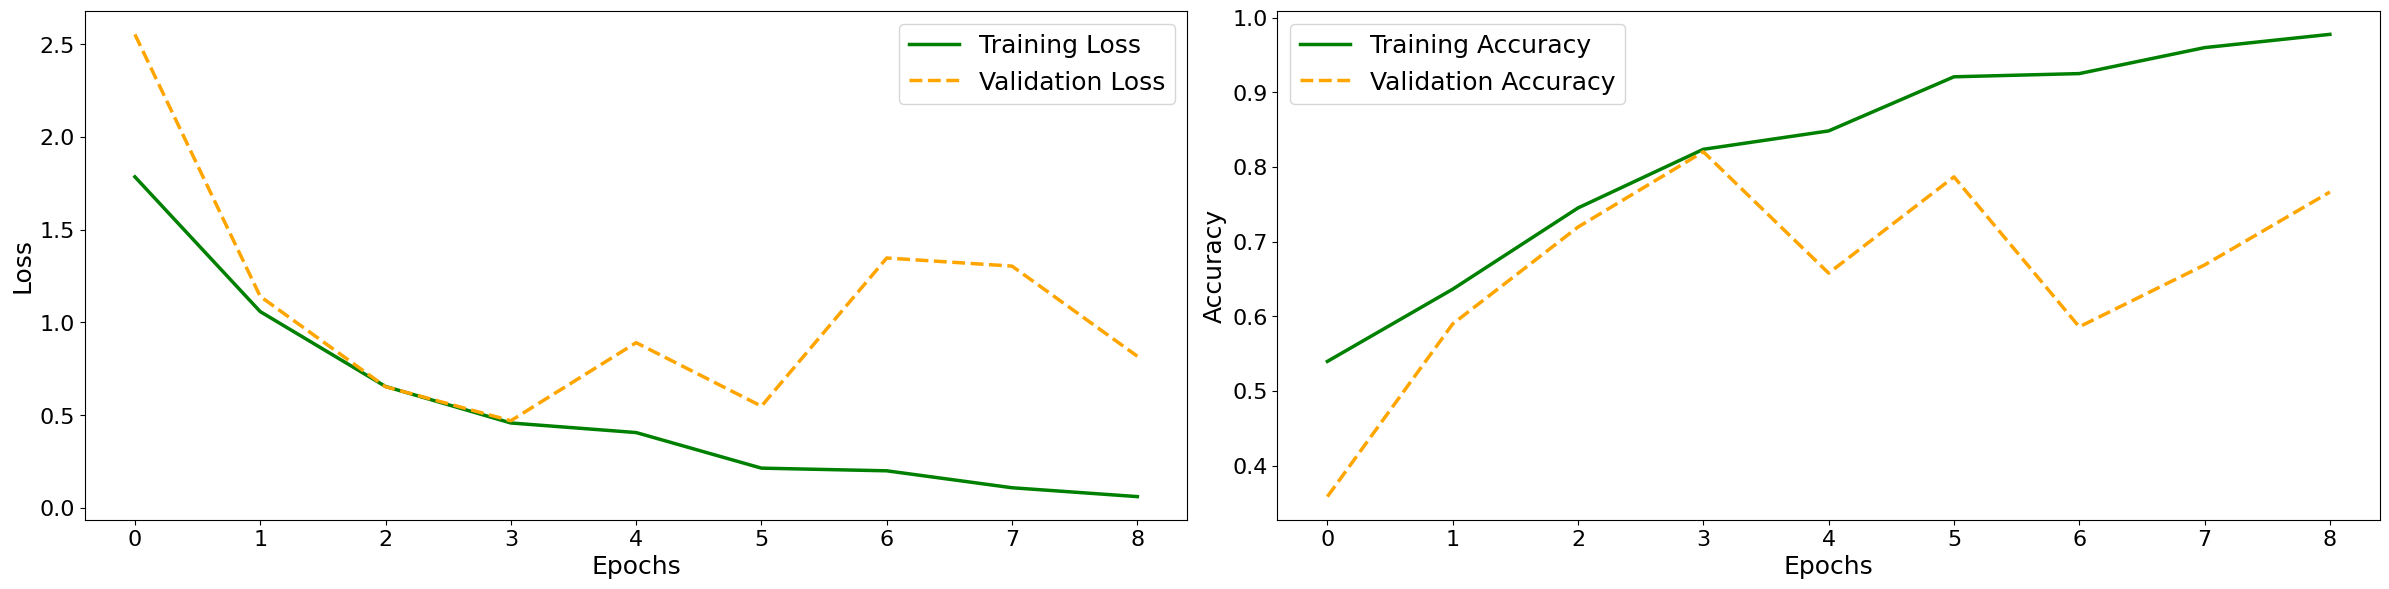

In [0]:
bucket_name="databricks-workspace-stack-brad-personal-bucket"
s3_file_name='AD_MRI_classification/results/history_resnet50.pkl'
history = load_pickle_s3(bucket_name, s3_file_name, dbutils)
clear_output(wait=False)

visualize_training(history)

We can see that model training stopped after only 8 epochs due to our early stopping criteria - Validation loss began increasing after the third epoch and never recovered. Ideally, by fine tuning this model by unfreezing layers/parameters, we can obtain a better fit.

Fine tune the ResNet50

In [0]:
# Load model
bucket_name="databricks-workspace-stack-brad-personal-bucket"
s3_file_path='AD_MRI_classification/results/model_resnet50.h5'
res_model = load_model_s3(bucket_name, s3_file_path, dbutils)

# Unfreeze last whole convolutional block for fine tuning
# (rather than all, since this is a small dataset)
fine_tune_at = 143
for layer in res_model.get_layer('resnet50').layers[fine_tune_at:]: # only unfreeze layers in ResNet50 backbone
  layer.trainable = True

# Print layers to verify in resnet50 backbone
for i, layer in enumerate(res_model.get_layer('resnet50').layers[140:], start=140):
    print(f"Layer {i}: {layer.name}, Trainable: {layer.trainable}")

std_learning_rate = 1e-5 # use lower learning rate with more trainable layers
res_model.compile(
    optimizer = keras.optimizers.Adam(learning_rate = std_learning_rate),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

res_model.summary()
        

Layer 140: conv4_block6_3_bn, Trainable: False
Layer 141: conv4_block6_add, Trainable: False
Layer 142: conv4_block6_out, Trainable: False
Layer 143: conv5_block1_1_conv, Trainable: True
Layer 144: conv5_block1_1_bn, Trainable: True
Layer 145: conv5_block1_1_relu, Trainable: True
Layer 146: conv5_block1_2_conv, Trainable: True
Layer 147: conv5_block1_2_bn, Trainable: True
Layer 148: conv5_block1_2_relu, Trainable: True
Layer 149: conv5_block1_0_conv, Trainable: True
Layer 150: conv5_block1_3_conv, Trainable: True
Layer 151: conv5_block1_0_bn, Trainable: True
Layer 152: conv5_block1_3_bn, Trainable: True
Layer 153: conv5_block1_add, Trainable: True
Layer 154: conv5_block1_out, Trainable: True
Layer 155: conv5_block2_1_conv, Trainable: True
Layer 156: conv5_block2_1_bn, Trainable: True
Layer 157: conv5_block2_1_relu, Trainable: True
Layer 158: conv5_block2_2_conv, Trainable: True
Layer 159: conv5_block2_2_bn, Trainable: True
Layer 160: conv5_block2_2_relu, Trainable: True
Layer 161: conv

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 3)    │            30 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 4, 4, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │       131,076 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,718,818 (90.48 MB)

 Trainable params: 15,107,106 (57.63 MB)

 Non-trainable params: 8,611,712 (32.85 MB)

Notice how the number of trainable parameters has increased from ~5M to ~15M by unfreezing the last convolutional block of the ResNet50 backbone. This should allow better fitting to the current data type.

In [0]:
# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history_fine_tune = res_model.fit(
    train_data,
    train_lab_cat,
    epochs=20, 
    validation_data=(test_data, test_lab_cat),
    callbacks=[early_stopping]
)

clear_output(wait=False)

In [0]:
# Save model and history files
bucket_name="databricks-workspace-stack-brad-personal-bucket"
s3_file_path='AD_MRI_classification/results/model_resnet50_fine_tune.h5'
save_model_s3(res_model, bucket_name, s3_file_path, dbutils)

bucket_name="databricks-workspace-stack-brad-personal-bucket"
s3_file_path='AD_MRI_classification/results/history_resnet50_fine_tune.pkl'
save_pickle_s3(history_fine_tune, bucket_name, s3_file_path, dbutils)

Model uploaded to S3 bucket: databricks-workspace-stack-brad-personal-bucketAD_MRI_classification/results/model_resnet50_fine_tune.h5
Data uploaded to S3 bucket: databricks-workspace-stack-brad-personal-bucket/AD_MRI_classification/results/history_resnet50_fine_tune.pkl


/databricks/python/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 46 variables whereas the saved optimizer has 90 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


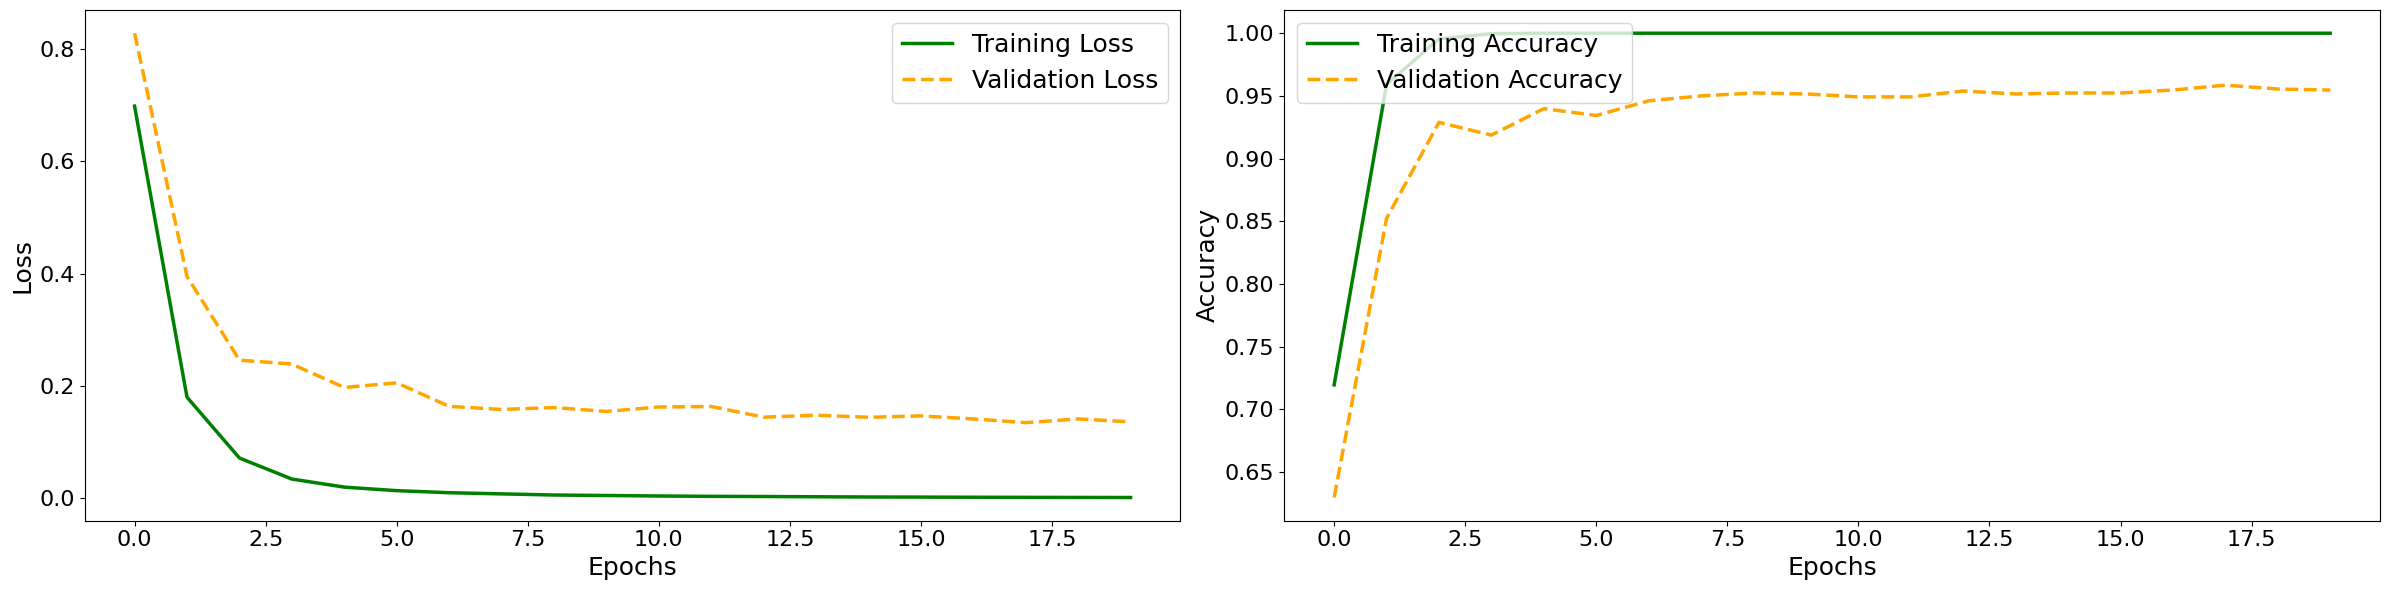

In [0]:
bucket_name="databricks-workspace-stack-brad-personal-bucket"
s3_file_name='AD_MRI_classification/results/history_resnet50_fine_tune.pkl'
history = load_pickle_s3(bucket_name, s3_file_name, dbutils)

visualize_training(history)

Clearly, we can see that we unfreezing additional layers in the ResNet50 model, performance increases dramatically. Performance is not only more stable that the original ResNet50 model and the custom CNN in the previous notebook, but plateaus at a higher overall accuracy. Next, we will see if we can maintain that accuracy when simplifying the model through pruning.

Prune model

In [0]:
# Load fine-tuned model
bucket_name="databricks-workspace-stack-brad-personal-bucket"
s3_file_path='AD_MRI_classification/results/model_resnet50_fine_tune.h5'
pre_pruned_model = load_model_s3(bucket_name, s3_file_path, dbutils)

results = []
pruning_factors = np.arange(0, 1, 0.05)
for factor in pruning_factors:
    
    # Prune and re-compile model
    pruned_model = global_prune_model(pre_pruned_model, pruning_factor=factor)
    pruned_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

    test_loss, test_accuracy = pruned_model.evaluate(test_data, test_lab_cat, batch_size=32)

    # Calculate the number of parameters in the pruned model
    total_params = np.sum([np.count_nonzero(layer.get_weights()[0]) for layer in pruned_model.layers if len(layer.get_weights()) > 0])

    # Save results
    results.append({
        'pruning_factor': factor,
        'total_params': total_params,
        'test_accuracy': test_accuracy,
        'test_loss': test_loss
    })
    
clear_output(wait=False)

# Save history file
bucket_name="databricks-workspace-stack-brad-personal-bucket"
s3_file_path='AD_MRI_classification/results/history_resnet50_fine_tune_pruning.pkl'
save_pickle_s3(results, bucket_name, s3_file_path, dbutils)

Data uploaded to S3 bucket: databricks-workspace-stack-brad-personal-bucket/AD_MRI_classification/results/history_resnet50_fine_tune_pruning.pkl


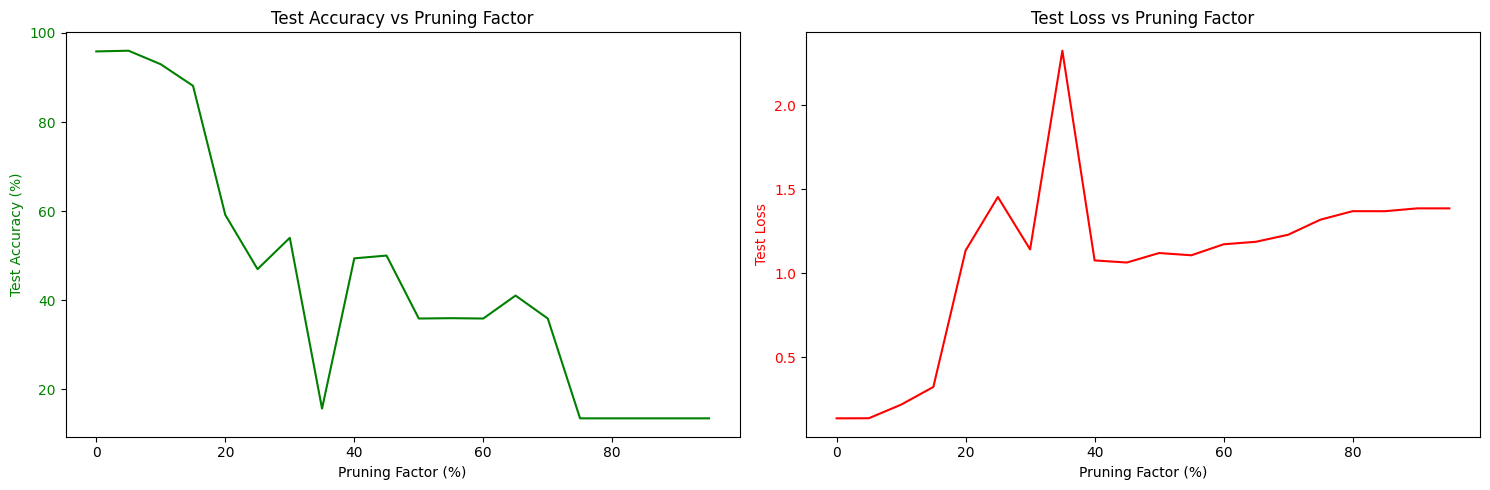

In [0]:
# Load history file
bucket_name="databricks-workspace-stack-brad-personal-bucket"
s3_file_path='AD_MRI_classification/results/history_resnet50_fine_tune_pruning.pkl'
history_prune=load_pickle_s3(bucket_name, s3_file_path, dbutils)

pruning_factors = np.array([result['pruning_factor'] * 100 for result in results])
total_params = np.array([result['total_params'] for result in results])
test_accuracies = np.array([result['test_accuracy'] * 100 for result in results])
test_losses = np.array([result['test_loss'] for result in results])

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot Test Accuracy
axes[0].plot(pruning_factors, test_accuracies, 'g-')
axes[0].set_xlabel('Pruning Factor (%)')
axes[0].set_ylabel('Test Accuracy (%)', color='g')
axes[0].tick_params(axis='y', labelcolor='g')
axes[0].set_title('Test Accuracy vs Pruning Factor')

# Plot Test Loss
axes[1].plot(pruning_factors, test_losses, 'r-')
axes[1].set_xlabel('Pruning Factor (%)')
axes[1].set_ylabel('Test Loss', color='r')
axes[1].tick_params(axis='y', labelcolor='r')
axes[1].set_title('Test Loss vs Pruning Factor')

plt.tight_layout()
plt.show()

While this is not a true pruning approach as the model is not re-structured after removing weights, this proof-of-concept pseudo-pruning gives us a sense of how many weights are likely to be important. With this, we can estimate that the model can be condensed ~15% without notably reducing performance. 